# Preparación de los datos

### Librerías

In [1]:
import medmnist
from medmnist import INFO
from medmnist.dataset import DermaMNIST

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import dataset_without_pytorch
from dataset_without_pytorch import get_loader

from sklearn.cluster import KMeans

### Carga y preparación de datos DermaMNIST

Carga y prepara el conjunto de datos DermaMNIST. Configura parámetros clave como épocas, tamaño de lote y tasa de aprendizaje, obtiene la clase del dataset (de las 7 existentes), y organiza los datos en un DataLoader para facilitar su procesamiento en lotes.

In [2]:
data_flag = 'dermamnist'
download = True

BATCH_SIZE = 128 #Lote tamanio

info_28 = INFO[data_flag] # Info

# Obtener dinamicamente la clase del conjunto de datos desde un modulo
DataClass_28 = getattr(dataset_without_pytorch, info_28['python_class'])

train_dataset_28 = DataClass_28(split='train', download=download)

# Encapsular los datos en un DataLoader para hacer lotes
train_loader_28 = get_loader(dataset=train_dataset_28, batch_size=BATCH_SIZE)

Using downloaded and verified file: C:\Users\matun\.medmnist\dermamnist.npz


Acceso Directo a Imágenes y Etiquetas del Conjunto de Datos de Entrenamiento

In [3]:
images = train_dataset_28.imgs
labels = train_dataset_28.labels

## Reducción de datos en la clase 5: *Melanocytic Nevi*

Se aplica un reducción de elementos de magenes en la clase 5 dada su sobrerepresentación aplicando el algoritmo K Means para obtener una muestra representativa de 1000 magenes

In [4]:
images_class_5 = [image for image, label in zip(images, labels) if label == 5]

In [5]:
len(images_class_5)

4693

Convertir las imágenes a un formato adecuado para K-means (aplanar cada imagen), dado que las imágenes están en formato (28, 28, 3), las aplanamos a (28 * 28 * 3)

In [6]:
flattened_images = [image.flatten() for image in images_class_5]

Seleccionar las 1000 imágenes representativas

In [7]:
# Aplicar K-means con 1000 clusters
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit(flattened_images)

# Obtener los centros de los clusters
cluster_centers = kmeans.cluster_centers_

# Para cada centroide, encontrar la imagen más cercana en el conjunto original
selected_images = []
for center in cluster_centers:
    # Calcular la distancia entre el centroide y todas las imágenes
    distances = np.linalg.norm(flattened_images - center, axis=1)
    # Encontrar el índice de la imagen más cercana
    closest_image_index = np.argmin(distances)
    # Añadir la imagen más cercana a la lista de imágenes seleccionadas
    selected_images.append(images_class_5[closest_image_index])


### Reeestructuracon de los datos de entrenamiento

In [8]:
# Filtrar imágenes y etiquetas de todas las clases excepto la clase 5
images_other_classes = [image for image, label in zip(images, labels) if label != 5]
labels_other_classes = [label for label in labels if label != 5]

# Crear etiquetas para las imágenes seleccionadas de la clase 5
selected_labels = [5] * len(selected_images)

# Combinar las imágenes y etiquetas de las otras clases con las seleccionadas de la clase 5
new_images = images_other_classes + selected_images
new_labels = labels_other_classes + selected_labels

In [57]:
len(new_images)

3314

In [56]:
len(new_labels)

3314

Verificamos distribución de los datos

C:\Users\matun\AppData\Local\Temp\ipykernel_21580\3628801159.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_labels_scalar = [int(label) for label in new_labels]


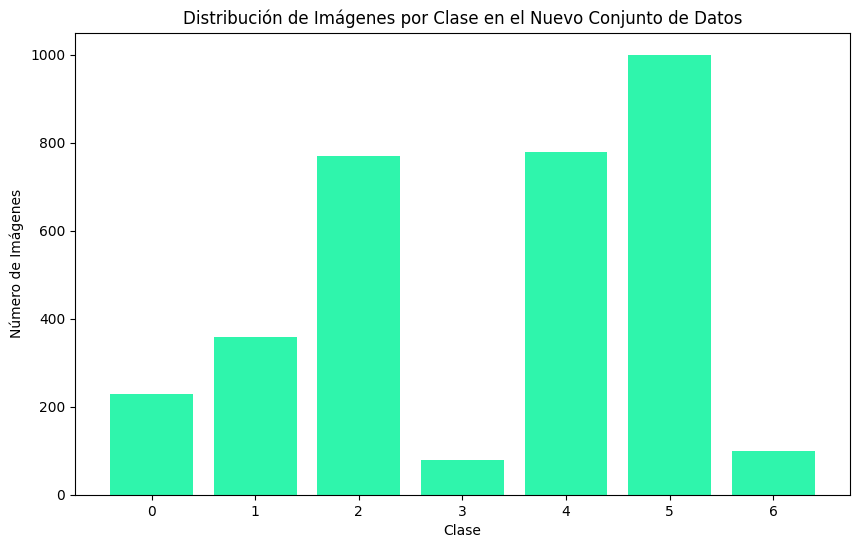

In [16]:
# Asegurarse de que las etiquetas sean valores escalares
new_labels_scalar = [int(label) for label in new_labels]

# Calcular el número de imágenes por clase
unique_classes = set(new_labels_scalar)
class_counts = {cls: new_labels_scalar.count(cls) for cls in unique_classes}

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='#2FF5AC')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase en el Nuevo Conjunto de Datos')
plt.xticks(list(class_counts.keys()))
plt.show()

## Aumento de imagenes en la clase 3 y 6

Se verifica que todos los datos de la lista de eiquetas sean enteros

In [61]:
new_labels = [int(label[0]) if isinstance(label, (list, np.ndarray)) else int(label) for label in new_labels]

In [62]:
print([type(label) for label in new_labels])

[<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'i

In [64]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


new_images = np.array(new_images)
new_labels = np.array(new_labels)

# Calcular la distribución de clases
unique, counts = np.unique(new_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Calcular el promedio de imágenes por clase
average_images = int(np.mean(list(class_distribution.values())))

# Crear un generador de datos para rotación
datagen = ImageDataGenerator(rotation_range=40)

# Listas para las imágenes y etiquetas aumentadas
augmented_images = []
augmented_labels = []

# Aumentar imágenes en las clases 3 y 6 hasta alcanzar el promedio
target_classes = [3, 6]
for target_class in target_classes:
    class_images = new_images[new_labels == target_class]
    current_count = class_distribution[target_class]
    images_to_add = average_images - current_count

    if images_to_add > 0:
        for i in range(images_to_add):
            # Seleccionar una imagen aleatoria de la clase
            img = class_images[i % len(class_images)]
            img = np.expand_dims(img, 0)  # Expande dimensiones para el generador

            # Generar una imagen aumentada
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0].astype(np.uint8))  # Agregar imagen aumentada
                augmented_labels.append(target_class)
                break  # Solo necesitamos una imagen por iteración

# Agregar las imágenes aumentadas al conjunto original
new_images = np.concatenate([new_images, np.array(augmented_images)])
new_labels = np.concatenate([new_labels, np.array(augmented_labels)])

# Confirmar la nueva distribución
unique, counts = np.unique(new_labels, return_counts=True)
new_class_distribution = dict(zip(unique, counts))

print("Distribución de clases después del aumento de datos:", new_class_distribution)

Distribución de clases después del aumento de datos: {0: 228, 1: 359, 2: 769, 3: 473, 4: 779, 5: 1000, 6: 473}


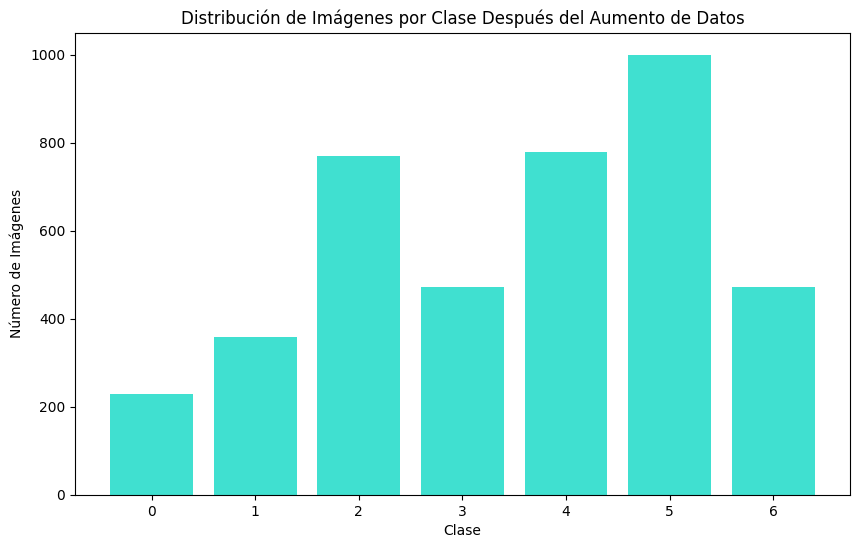

In [65]:
plt.figure(figsize=(10, 6))
plt.bar(new_class_distribution.keys(), new_class_distribution.values(), color='turquoise')
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de Imágenes por Clase Después del Aumento de Datos")
plt.show()

# ISOMAP Nuevo

In [ ]:
# Aplanar las imágenes
flat_images = new_images.reshape(new_images.shape[0], -1)

# Obtener etiquetas únicas y el número de clases
unique_labels = np.unique(new_labels)
num_classes = len(unique_labels)
cmap = plt.get_cmap('tab10', num_classes)  # Mapa de colores

# Aplicar Isomap
embedding = Isomap(n_components=2)
iso = embedding.fit_transform(flat_images)
print(iso.shape)
# Graficar los resultados
plt.figure(figsize=(12, 12))
scatter = plt.scatter(iso[:, 0], iso[:, 1], c=new_labelslabels, cmap=cmap, alpha=0.8, edgecolor='k')
plt.colorbar(scatter, ticks=range(num_classes), label='Clase')

# Configuración adicional para los ejes y título
plt.title('Isomap de DermMNIST por Clase con nueva distribución', fontsize=16)
plt.xlabel('Componente Isomap 1', fontsize=14)
plt.ylabel('Componente Isomap 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()